In [88]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [89]:
train_df = pd.read_csv('/Users/defeee/Documents/GitHub/FormAI-ML/Computer_Vision/squat_features_with_labels_TRAIN.csv')
test_df = pd.read_csv('/Users/defeee/Documents/GitHub/FormAI-ML/Computer_Vision/squat_features_with_labels_TEST.csv')

merged_df = pd.concat([train_df, test_df], ignore_index=True)
merged_df.columns = merged_df.columns.str.strip()
merged_df.dropna(inplace=True)

labels = merged_df[['Bent_Over_Squat', 'Deep_Squat', 'Good_Squat', 'Heels_Off_Squat', 'Shallow_Squat']].values
data = merged_df.drop(['filename', 'Bent_Over_Squat', 'Deep_Squat', 'Good_Squat', 'Heels_Off_Squat', 'Shallow_Squat'], axis=1)

# All but good squats are bad squats, one hot encode good and bad squats
labels = np.array([labels[:, 2], np.sum(labels[:, [0,1,3,4]], axis=1)]).T  # Sum along axis=1 for each row
labels = np.argmax(labels, axis=1)

# Normalize the data

# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)

train_data, temp_data, train_labels, temp_labels = train_test_split(
    data, labels, test_size=0.3, random_state=42
)

test_data, val_data, test_labels, val_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5,
 random_state=42
)


In [90]:
from tensorflow.keras.utils import to_categorical

# Assuming your original labels are in train_labels, val_labels, test_labels
train_labels = to_categorical(train_labels, num_classes=2)
val_labels = to_categorical(val_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [91]:
model = keras.Sequential([
    layers.Input(shape=(5, 1)), 
    layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # Output layer with 2 units
])

In [92]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)


In [93]:
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5109 - loss: 1.0509 - val_accuracy: 0.4242 - val_loss: 0.9007
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7735 - loss: 0.5417 - val_accuracy: 0.5758 - val_loss: 0.6929
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8219 - loss: 0.3420 - val_accuracy: 0.6061 - val_loss: 0.6867
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8887 - loss: 0.2580 - val_accuracy: 0.5758 - val_loss: 0.7077
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9494 - loss: 0.1801 - val_accuracy: 0.6364 - val_loss: 0.6772
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9799 - loss: 0.1260 - val_accuracy: 0.6667 - val_loss: 0.6723
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9886 - loss: 0.0798 - val_accuracy: 0.5758 - val_loss: 0.6872
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9922 - loss: 0.0639 - val_accuracy: 0.6667 - val_loss: 0.6761

In [94]:
loss, accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8125 - loss: 0.7224
Test Loss: 0.7224
Test Accuracy: 0.8125


In [95]:
# Predictions for ROC AUC, F1 score, and confusion matrix
y_pred = model.predict(test_data)
y_pred_binary = (y_pred > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


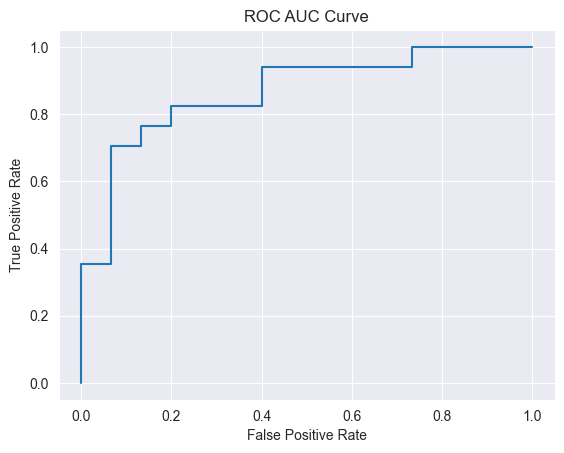

ROC AUC: 0.8667
Accuracy: 0.8125
F1 Score: 0.8110


In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,accuracy_score, f1_score
from sklearn.metrics import roc_curve, confusion_matrix
import seaborn as sns
y_pred_positive = y_pred[:, 0]

# ROC AUC curve and scores
roc_auc = roc_auc_score(test_labels, y_pred)
accuracy = accuracy_score(test_labels, y_pred_binary)
# Assuming you want a weighted average to account for label imbalance
f1 = f1_score(test_labels, y_pred_binary, average='weighted')

test_labels_binary = test_labels[:, 0]  # Convert one-hot encoded labels to binary
fpr, tpr, _ = roc_curve(test_labels_binary, y_pred_positive)  # Use y_pred_positive here
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.show()

print(f'ROC AUC: {roc_auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

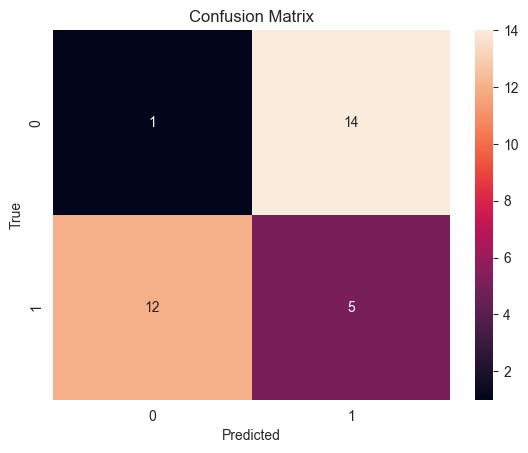

In [97]:
import numpy as np

y_pred_binary = np.argmax(y_pred, axis=1)  # Or use a threshold for binary conversion

# ... (rest of your code) ...

# Confusion matrix (using binary labels)
cm = confusion_matrix(test_labels_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

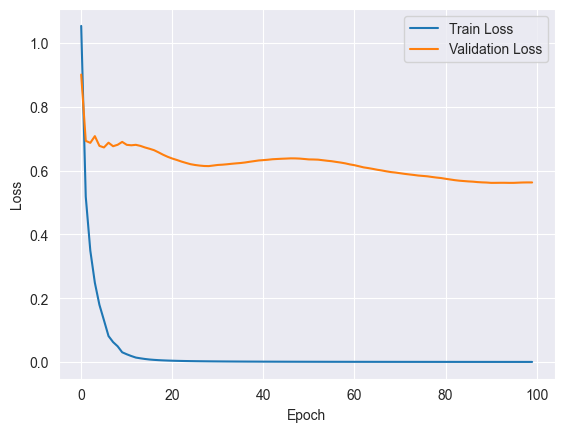

In [98]:
# Plot the loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [99]:
# save model to h5 file
model.save('squat_model_tf2.h5')